In [2]:
import os 
import glob

basedir = 'vehicles/vehicles/'
#Different folders represent different sources for images e.g. GTI,KITTI,etc. 
image_types = os.listdir(basedir)
cars=[]
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of vehicle Images found:',len(cars))
with open("cars.txt",'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        
basedir = 'non-vehicles/non-vehicles/'
#Different folders represent different sources for images e.g. GTI,KITTI,etc. 
image_types = os.listdir(basedir)
notcars=[]
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of vehicle Images found:',len(notcars))
with open("notcars.txt",'w') as f:
    for fn in notcars:
        f.write(fn+'\n')


Number of vehicle Images found: 8792
Number of vehicle Images found: 8968


In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

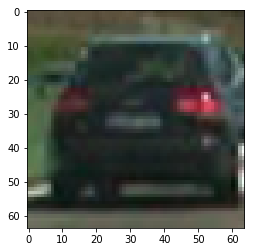

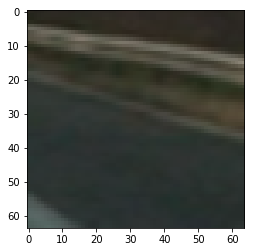

In [183]:
idx1 = np.random.randint(0,len(cars))
idx2 = np.random.randint(0,len(notcars))

car_img = mpimg.imread(cars[idx1])
notcar_img = mpimg.imread(notcars[idx1])
plt.figure()
plt.imshow(car_img)
plt.figure()
plt.imshow(notcar_img)

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel() 
    color2 = cv2.resize(img[:,:,1], size).ravel() 
    color3 = cv2.resize(img[:,:,2], size).ravel() 
    # Return the feature vector
    features = np.hstack((color1,color2,color3))
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [6]:
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    # Create a list to append feature vectors to
    img_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            if vis==True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        img_features.append(hog_features)
    if vis==True:
        return np.concatenate(img_features),hog_image
    else:
        return np.concatenate(img_features)

In [7]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [8]:
def visualize(fig,rows,cols,imgs, titles):
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

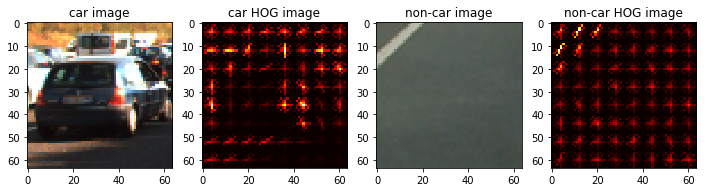

In [9]:
%matplotlib inline

idx1 = np.random.randint(0,len(cars))
idx2 = np.random.randint(0,len(notcars))

car_img = mpimg.imread(cars[idx1])
notcar_img = mpimg.imread(notcars[idx1])

#Define parameters for the features
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 1
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features,car_hog_img = single_img_features(car_img, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
notcar_features,notcar_hog_img = single_img_features(notcar_img, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
images = [car_img,car_hog_img,notcar_img,notcar_hog_img]
titles = ['car image','car HOG image','non-car image','non-car HOG image']
rows = 1
fig = plt.figure(figsize=(12,3))
cols = 4
visualize(fig,rows,cols,images,titles)

In [45]:
#Define parameters for the features
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(cars),n_samples)
test_cars = cars#np.array(cars)[random_idxs]
test_notcars = notcars#np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


134.59 Seconds to extract HOG features...
Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9636


In [46]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

from sklearn.externals import joblib
joblib.dump(svc, 'filename.pkl') 

29.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9865
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
0.40427 Seconds to predict 10 labels with SVC


['filename.pkl']

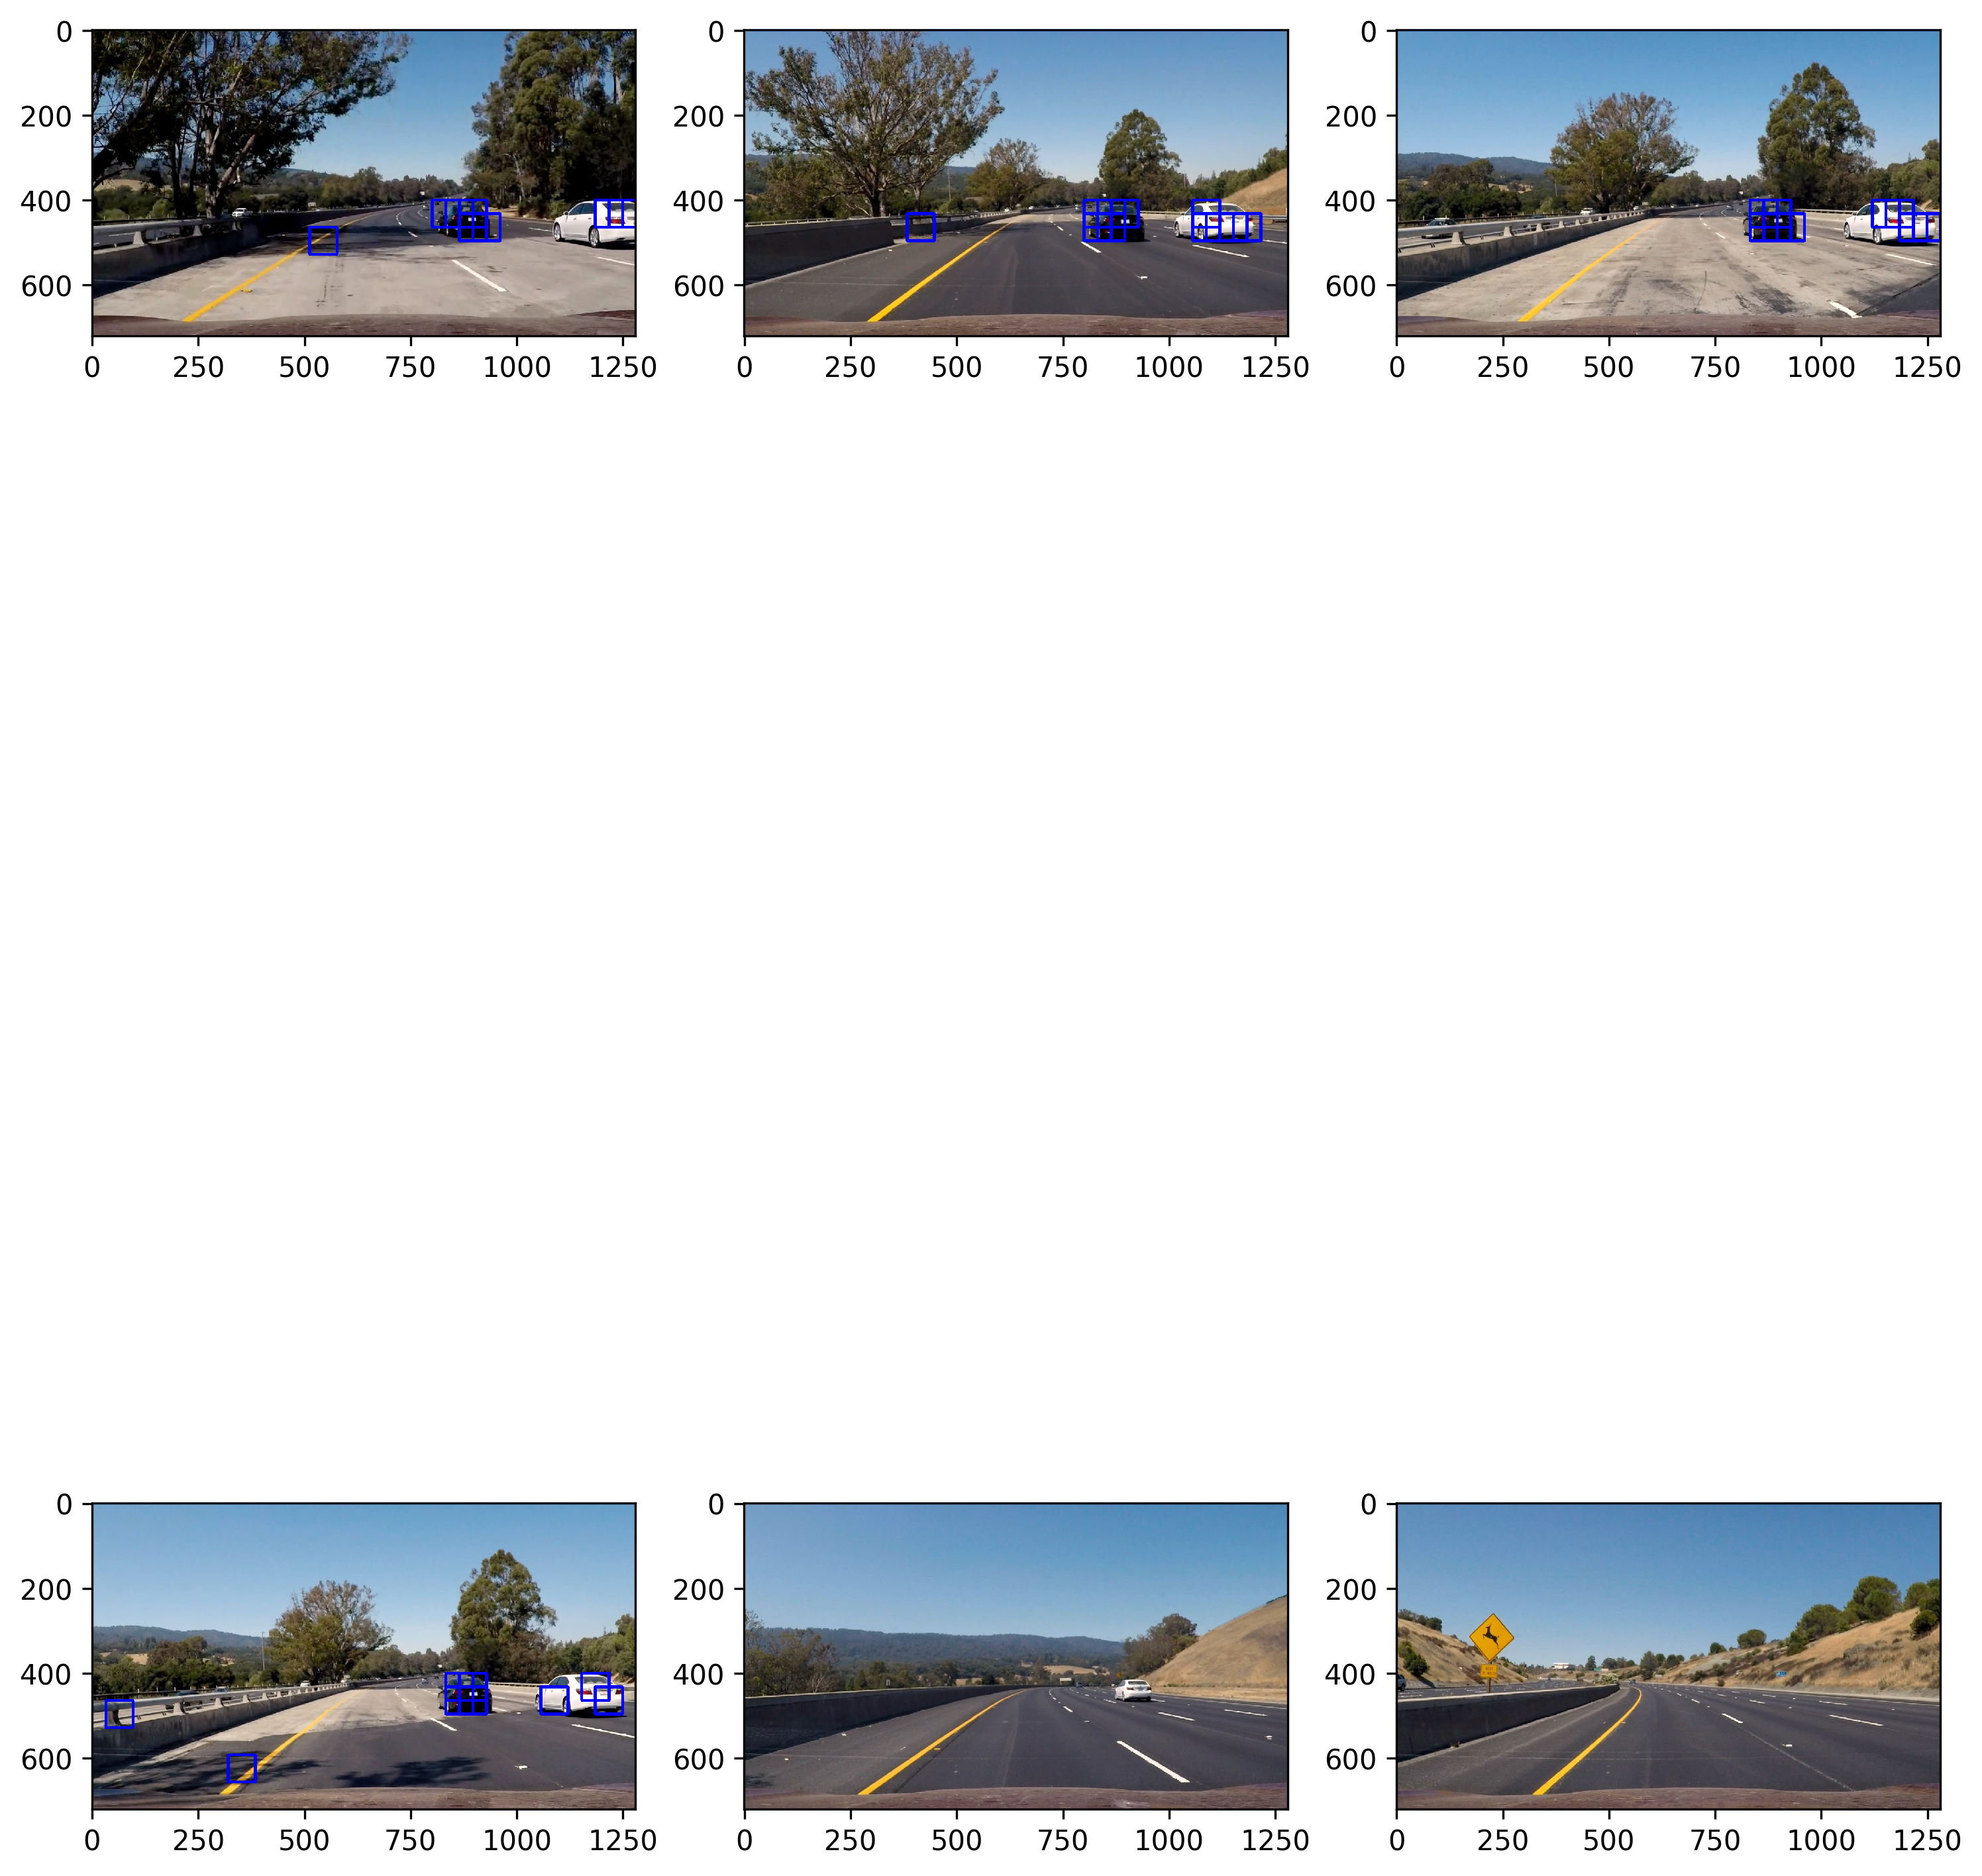

In [47]:
from sklearn.externals import joblib
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
clf = joblib.load('filename.pkl') 
imgs = glob.glob('./test_images/*')
images = []
titles = []
for img_src in imgs:
    img = mpimg.imread(img_src)
    draw_image = np.copy(img)
    image = img.astype(np.float32)/255
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(window_img)
    titles.append('')
fig = plt.figure(figsize=(12,18),dpi=300)
visualize(fig,2,3,images,titles)

In [49]:
def convert_color(img,conv='RGB2YCrCb'):
    if conv=='RGB2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2LUV)


In [50]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Number of windows = 294
Number of windows = 294
Number of windows = 294
Number of windows = 294
Number of windows = 294
Number of windows = 294
Number of windows = 294
Number of windows = 294
Number of windows = 294
Number of windows = 294
Number of windows = 294
Number of windows = 294


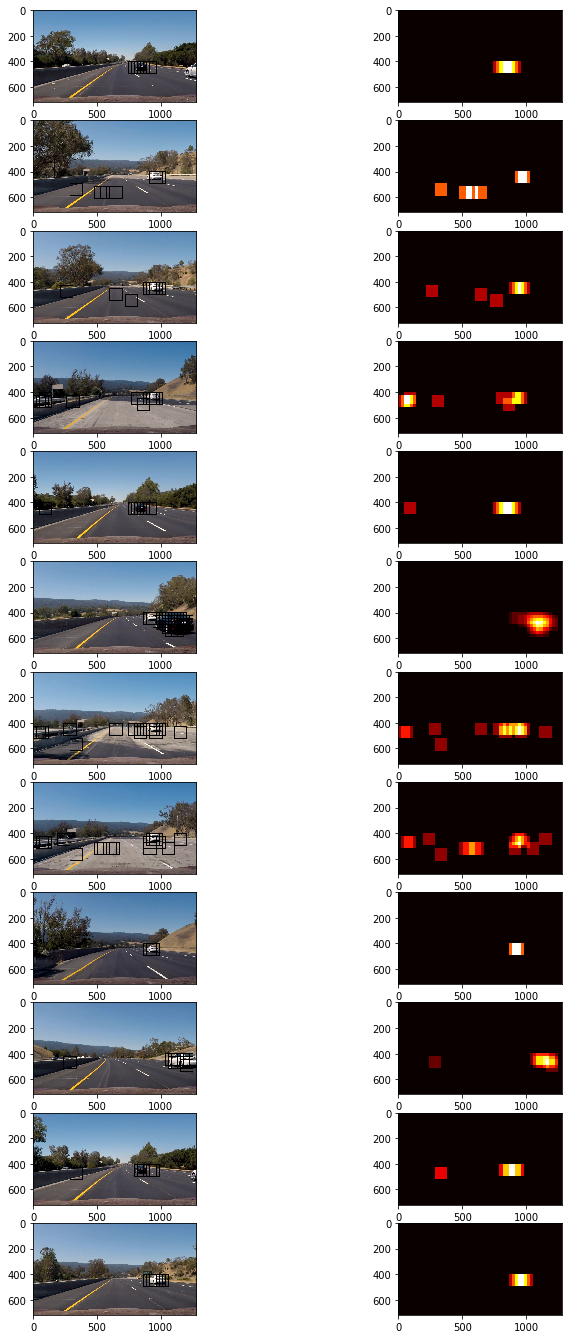

In [52]:
from sklearn.externals import joblib
clf = joblib.load('filename.pkl')

#Define parameters for the features
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

out_images=[]
out_titles= []
imgs = glob.glob('./new_test_images/*')
ystart = 400
ystop = 656
scale = 1.5

for img_src in imgs:
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    boxes = []
    heatmap = np.zeros_like(img[:,:,0])
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count+=1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw]+=1
    
    out_images.append(draw_img)
    out_images.append(heatmap)
    out_titles.append('')
    out_titles.append('')
    print('Number of windows = {}'.format(count))
fig = plt.figure(figsize=(12,24))
visualize(fig,12,2,out_images,out_titles)

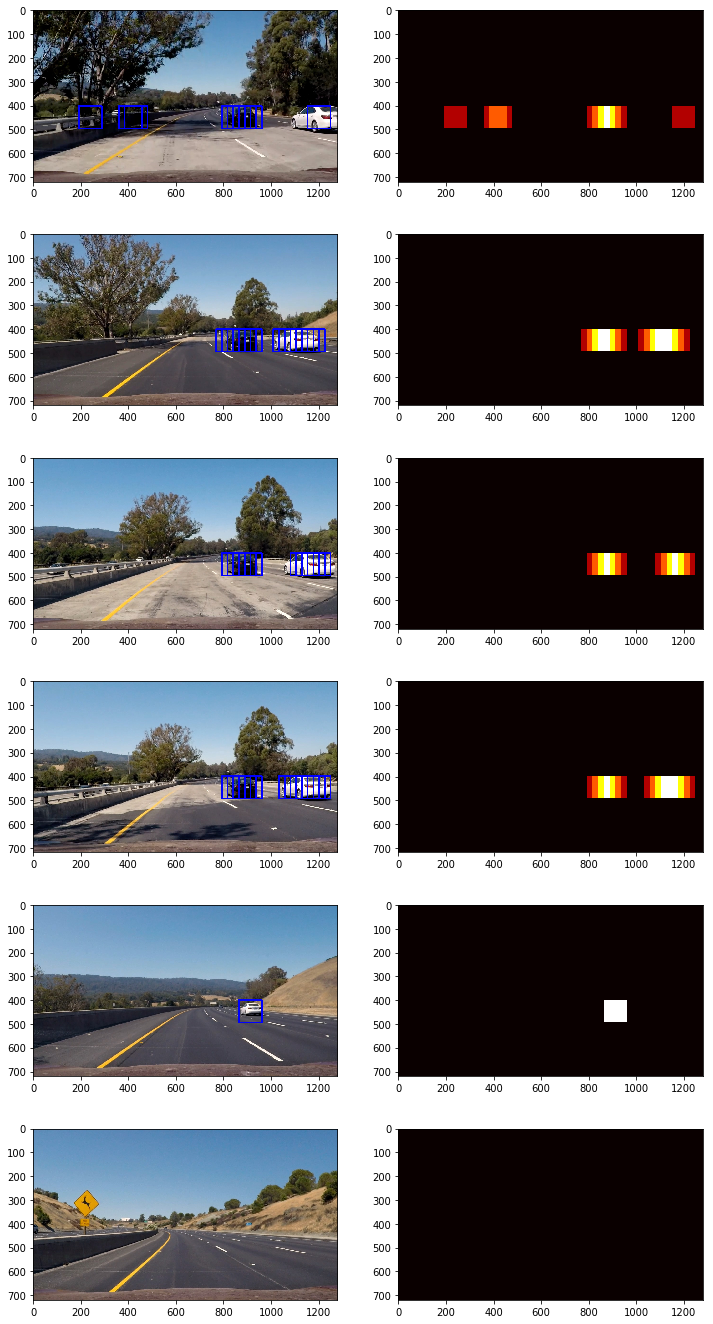

In [170]:
def find_cars(img,ystart,ystop,scale):
    draw_img = np.copy(img)
#     heatmap = np.zeros_like(img[:,:,0])
#     heatmap_smooth = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    out_boxes=[]
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                out_boxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
#                 heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw]+=1
                
#     heatmap_queue.append(heatmap)
#     heatmap_smooth = np.mean(np.array(heatmap_queue),axis=0,dtype=np.uint8)
#     heatmap = apply_threshold(heatmap_smooth,2)
    
    return out_boxes

imgs = glob.glob('./test_images/*')
out_images=[]
out_titles= []

for img_src in imgs:
    img = mpimg.imread(img_src)
    heatmap = np.zeros_like(img[:,:,0])
    boxes = []
    boxes = find_cars(img,400,460,0.8)  
    boxes += find_cars(img,400,480,1.2)
    boxes += find_cars(img,400,530,1.5)
    boxes += find_cars(img,470,656,2)
    draw_img = draw_boxes(img, boxes, color=(0, 0, 255), thick=6)
    heatmap = add_heat(heatmap,boxes)
#     heatmap = apply_threshold(heatmap,1)
    out_images.append(draw_img)
    out_images.append(heatmap)
    out_titles.append('')
    out_titles.append('')

fig = plt.figure(figsize=(12,24))
visualize(fig,6,2,out_images,out_titles)

In [63]:
# # Define a single function that can extract features using hog sub-sampling and make predictions
# from collections import deque
# heatmap_queue = deque(maxlen=15)

# def find_cars(img,scale):
#     draw_img = np.copy(img)
#     heatmap = np.zeros_like(img[:,:,0])
#     heatmap_smooth = np.zeros_like(img[:,:,0])
#     img = img.astype(np.float32)/255
    
#     out_boxes=[]
    
#     img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
#     if scale != 1:
#         imshape = ctrans_tosearch.shape
#         ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
#     ch1 = ctrans_tosearch[:,:,0]
#     ch2 = ctrans_tosearch[:,:,1]
#     ch3 = ctrans_tosearch[:,:,2]

#     # Define blocks and steps as above
#     nxblocks = (ch1.shape[1] // pix_per_cell) - 1
#     nyblocks = (ch1.shape[0] // pix_per_cell) - 1 
#     nfeat_per_block = orient*cell_per_block**2
    
#     # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
#     window = 64
#     nblocks_per_window = (window // pix_per_cell) - 1
#     cells_per_step = 2  # Instead of overlap, define how many cells to step
#     nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
#     nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
#     for xb in range(nxsteps):
#         for yb in range(nysteps):
#             ypos = yb*cells_per_step
#             xpos = xb*cells_per_step
#             # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

#             xleft = xpos*pix_per_cell
#             ytop = ypos*pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#             #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_prediction = clf.predict(test_features)
            
#             if test_prediction == 1:
#                 xbox_left = np.int(xleft*scale)
#                 ytop_draw = np.int(ytop*scale)
#                 win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
# #                 out_boxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
#                 heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw]+=1
                
#     heatmap_queue.append(heatmap)
#     heatmap_smooth = np.mean(np.array(heatmap_queue),axis=0,dtype=np.uint8)
#     heatmap = apply_threshold(heatmap_smooth,2)
    
#     return draw_img,heatmap
    

In [173]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        box_area = (np.max(nonzerox) - np.min(nonzerox)) * (np.max(nonzeroy) - np.min(nonzeroy))
        if box_area > 4096:
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

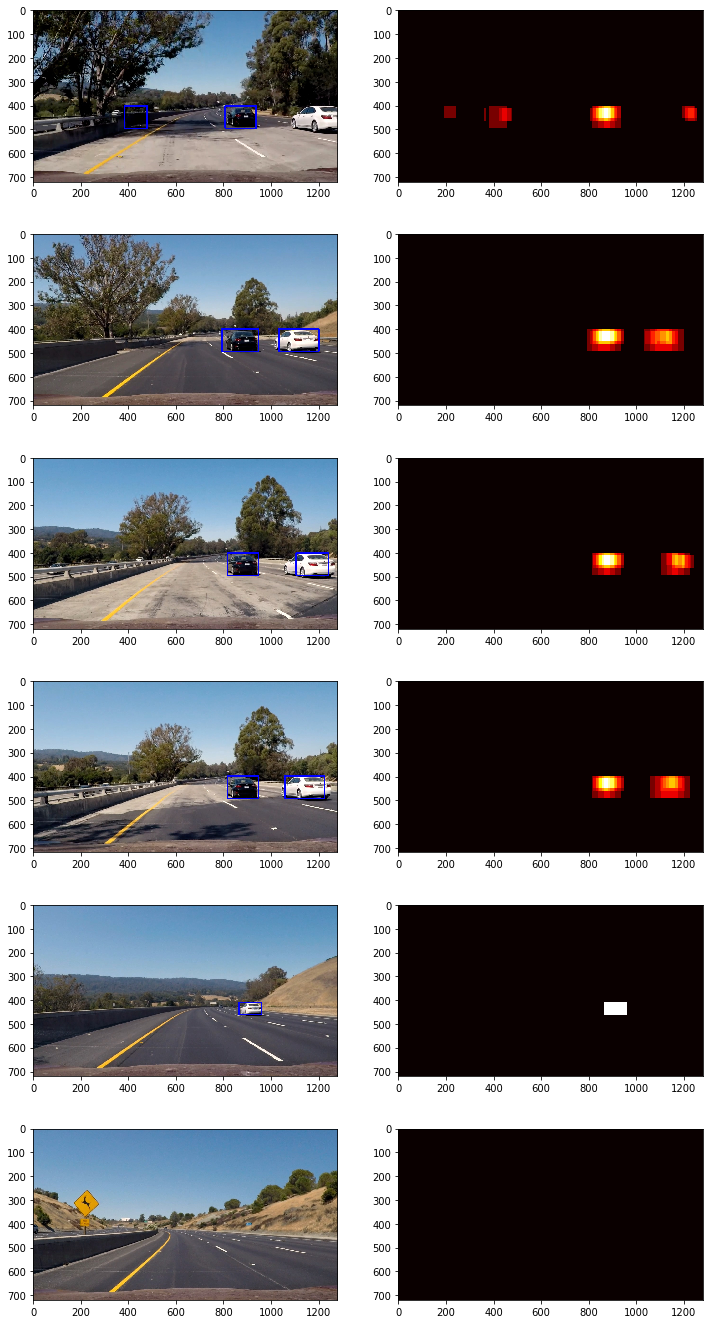

In [174]:
out_images = []
ystart = 400
ystop = 656
scale = 1.5
for img_src in imgs:
    img = mpimg.imread(img_src)
    heatmap = np.zeros_like(img[:,:,0])
    boxes = []
    boxes = find_cars(img,400,480,0.8)
    boxes += find_cars(img,400,480,1.2)
    boxes += find_cars(img,400,530,1.5)
    boxes += find_cars(img,470,656,2)
    draw_img = draw_boxes(img, boxes, color=(0, 0, 255), thick=6)
    heatmap = add_heat(heatmap,boxes)
    heatmap = apply_threshold(heatmap,1)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img),labels)
    out_images.append(draw_img)
    out_images.append(heatmap)
    
fig = plt.figure(figsize=(12,24))
visualize(fig,6,2,out_images,out_titles)

In [180]:
from collections import deque
heatmap_queue = deque(maxlen=8)
n_count=0

In [181]:
def process_img(img):
    global n_count,heatmap_queue
    if(n_count%2==0):
        heatmap = np.zeros_like(img[:,:,0])
        boxes = []
        boxes = find_cars(img,400,480,0.8)
        boxes += find_cars(img,400,480,1.2)
        boxes += find_cars(img,400,530,1.5)
        boxes += find_cars(img,470,656,2)
        draw_img = draw_boxes(img, boxes, color=(0, 0, 255), thick=6)
        heatmap = add_heat(heatmap,boxes)
        heatmap = apply_threshold(heatmap,1)
        heatmap_queue.append(heatmap)
        heatmap = np.mean(np.array(heatmap_queue),axis=0)
        heatmap = apply_threshold(heatmap,1)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img),labels)
    else:
        heatmap = np.zeros_like(img[:,:,0])
        heatmap = np.mean(np.array(heatmap_queue),axis=0)
        heatmap = apply_threshold(heatmap,1)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img),labels)
    n_count+=1
    return draw_img    

In [182]:
from moviepy.editor import VideoFileClip
white_output = 'test_videos_output/output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/output_video.mp4
[MoviePy] Writing video test_videos_output/output_video.mp4


100%|█████████▉| 1260/1261 [07:41<00:00,  2.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output_video.mp4 

CPU times: user 10min 4s, sys: 3.1 s, total: 10min 7s
Wall time: 7min 42s


In [89]:
# def extract_frames(video_file,times,postfix):
#     clip = VideoFileClip(video_file)
#     for t in times:
#             clip.save_frame('./output_images/{}'.format(t)+postfix+'.png',t)

In [90]:
# extract_frames('./test_videos_output/output_video.mp4',[25,26,27],'output_new')

In [16]:
# extract_frames('project_video.mp4',[9,18,20,21,22,23,24,25,30,47,48,49],'original')
# extract_frames('./test_videos_output/output_video.mp4',[9,18,20,21,22,23,24,25,30,47,48,49],'output')

In [18]:
# extract_frames('test_video.mp4',[0,0.5,1,1.5,2],'test')